In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoder_weights_decoding_1sec_dhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals = 'dhpcg1','dhpc24','dhpcg20'
expo_animals = 'dhpcg1','dhpc24','dhpcg20'
pre_animals = 'dhpcg1','dhpc24' #,'dhpcg20' #dHPC20 performed very well on day 1 (d' = 2)
post_animals = 'dhpcg1','dhpc24','dhpcg20'
renew_animals = 'dhpcg1','dhpc24','dhpcg20'
ext2_animals = 'dhpcg1','dhpc24','dhpcg20'
ext1_animals = 'dhpcg1','dhpc24','dhpcg20'

In [9]:
sessions = 'expo', 'pre', 'post', 'ext1', 'ext2', 'renew'

In [10]:
for sess in 'pre', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [11]:
#have to extract 2_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [12]:
#from referenced notebook, 16 time bins total beginning at -5s prior to odor onset and running through 11s post onset

#t_start0 = -5  # sec
#t_stop0 = 11  # sec

# CS BEGINS AT TIME BIN 6 (tb5)
# TRACE BEGINS AT TB 8
# REWARD DELIVERED AT TB 10

In [13]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None):
   
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [14]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [15]:
for sess in sessions:
    for t in range(16):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpcg1 expo dhpc24 expo dhpcg20 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 pre dhpcg1 pre dhpc24 post dhpcg1 post dhpc24 post dhpcg20 post dhpcg1 post dh

In [16]:
reference_tbs = range(16)

In [17]:
%%time
for t in range(16): # number of time bins
    exec('scores_tb_%s = {}'%t)
    n_loops = 30
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s"%t)[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess)) for i in range(n_loops)]]

expo 0 pre 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 3min 41s, sys: 200 ms, total: 3min 42s
Wall time: 3min 41s



## now take random cells and decode

In [18]:
%%time
random_cells=30
for t in range(16): # number of time bins
    exec('random_cells_scores_tb_%s = {}'%t)
    n_loops = 30
    for sess in sessions:
        print sess,
        print t,
        eval("random_cells_scores_tb_%s"%t)[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess),n_cells=random_cells) for i in range(n_loops)]]

expo 0 pre 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 1min 5s, sys: 184 ms, total: 1min 5s
Wall time: 1min 5s



In [19]:
def plot_scores(scores,col,last_plot,bins=16):
    for t in range(bins):
        scoresP = eval("%s_%s"%(scores,t))
        ax[col][0].plot(t-4.5, np.mean(scoresP['expo'])*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['expo'])*100
        s = np.std(scoresP['expo'])*100 / np.sqrt(scoresP['expo'].shape[-1])
        ax[col][0].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col][1].plot(t-4.5, np.mean(scoresP['pre'])*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['pre'])*100
        s = np.std(scoresP['pre'])*100 / np.sqrt(scoresP['pre'].shape[-1])
        ax[col][1].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col][2].plot(t-4.5, np.mean(scoresP['post'])*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['post'])*100
        s = np.std(scoresP['post'])*100 / np.sqrt(scoresP['post'].shape[-1])
        ax[col][2].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col][3].plot(t-4.5, np.mean(scoresP['ext1'])*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['ext1'])*100
        s = np.std(scoresP['ext1'])*100 / np.sqrt(scoresP['ext1'].shape[-1])
        ax[col][3].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col][4].plot(t-4.5, np.mean(scoresP['ext2'])*100, 'o', color='grey', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['ext2'])*100
        s = np.std(scoresP['ext2'])*100 / np.sqrt(scoresP['ext2'].shape[-1])
        ax[col][4].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col][5].plot(t-4.5, np.mean(scoresP['renew'])*100, 'o', color='y', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(scoresP['renew'])*100
        s = np.std(scoresP['renew'])*100 / np.sqrt(scoresP['renew'].shape[-1])
        ax[col][5].errorbar(t-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    
    for x in range (0,6):
        ax[0][0].set_ylim(0, 100)
        ax[0][0].set_xlim(-5.5, 11)
        ax[0][0].set_xticks(np.arange(-5,11, 5))
        ax[0][0].set_xticklabels(np.arange(-5,11, 5))
        for y in range(2):
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
            #ax[y][x].vlines(reference_tb/2.0-4.25,0,100,color='r',lw=0.5,linestyles='--')
        ax[0][0].set_ylabel('Performance %\n(all cells)')
        ax[0][0].set_title('Expo',fontsize=8)
        ax[0][1].set_title('Pre',fontsize=8)
        ax[0][2].set_title('Post',fontsize=8)
        ax[0][3].set_title('Ext1',fontsize=8)
        ax[0][4].set_title('Ext2',fontsize=8)
        ax[0][5].set_title('Reinstate',fontsize=8)
        fig.tight_layout(pad=3)
    
    if last_plot == True:
        ax[col][x].set_xlabel('Time from odor onset (s)',fontsize=6)
        ax[col][0].set_ylabel('ax[x][0].set_ylabel("title")')

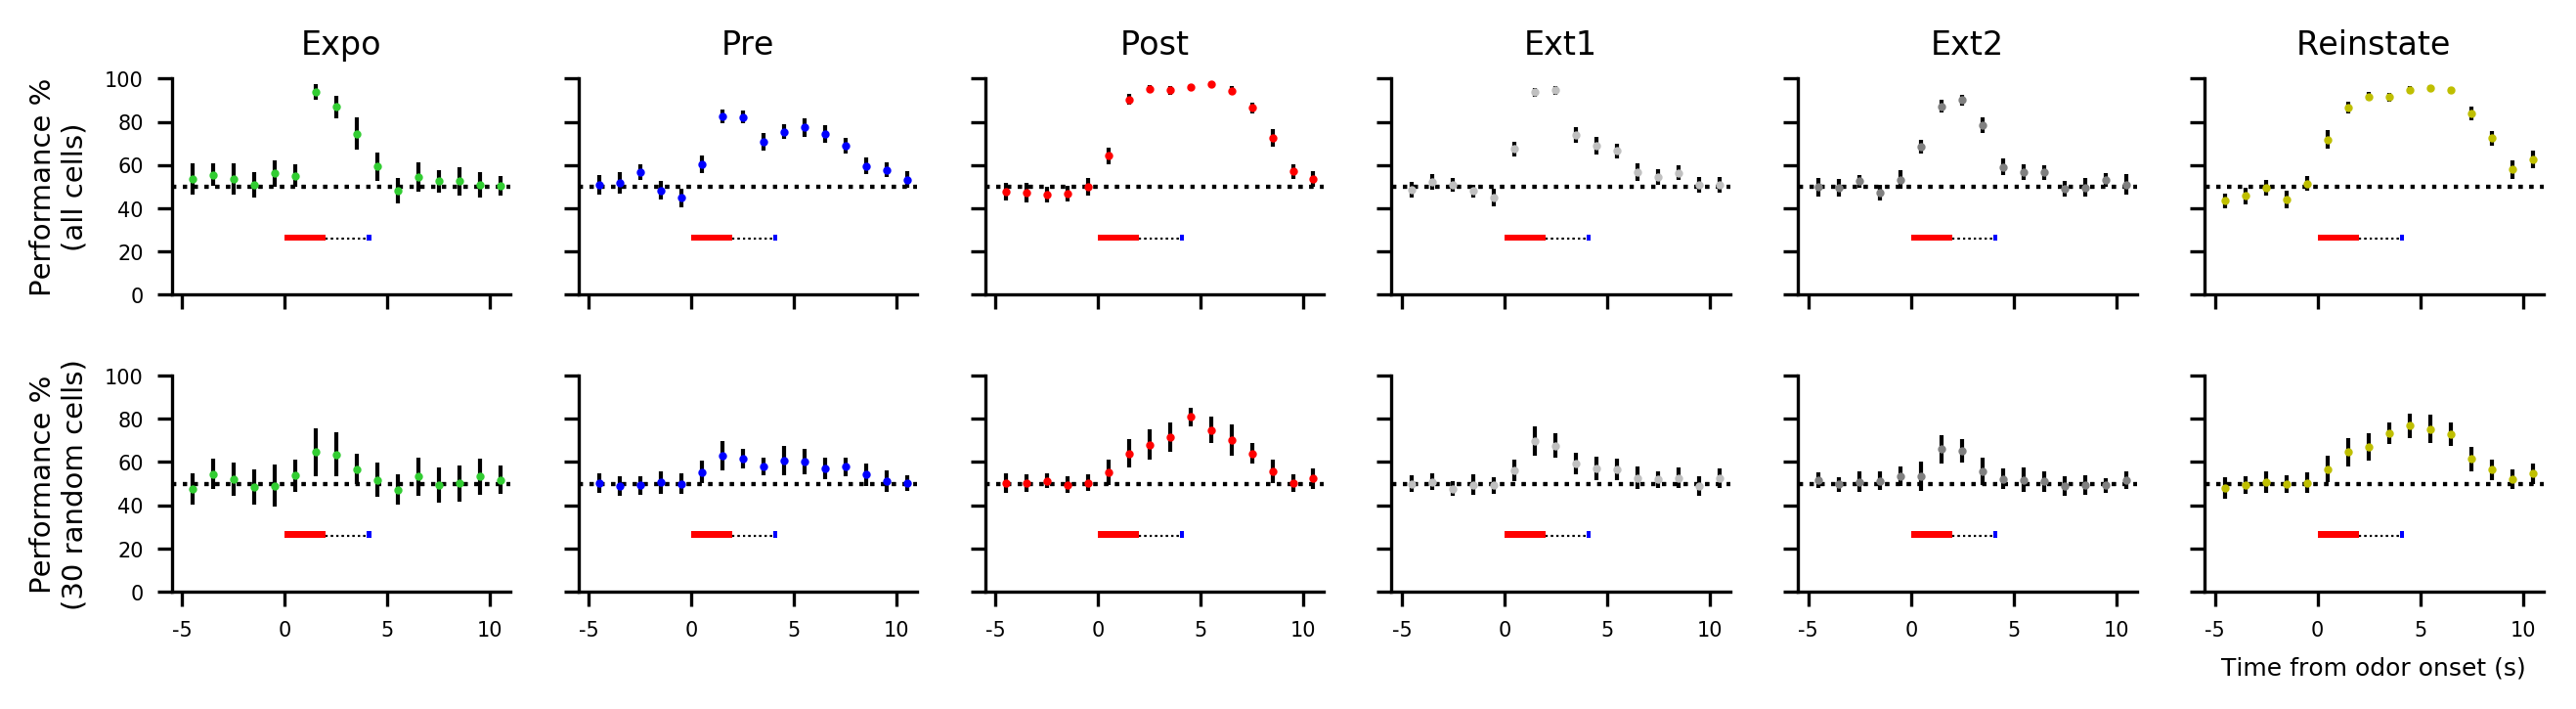

In [20]:
fig, ax = pl.subplots(2,6, figsize=(9, 2.5),sharex=True, sharey=True)

plot_scores('scores_tb',0,False)
plot_scores('random_cells_scores_tb',1,True)


ax[1][0].set_ylabel('Performance %\n(30 random cells)')


#fig.savefig('../img/%s_horizontal_tb_%s.jpg'%(NOTEBOOK_NAME,reference_tb))

In [21]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def trials_weights_decode(patterns_for_weights, patterns_for_decode, labels, top_cells=None, bottom_cells=None, percentage_above=None,
                          percentage_below=None, n_cells=None, start_trial=None, end_trial=None):
    
    #split trials into train and test
    which_train = {}
    which_test = {}
    for ani in patterns_for_weights.keys():
        if start_trial != None:   #take subset of trials?
            which_train_aa = np.random.permutation(np.where(labels[ani][start_trial:end_trial]==0)[0])
            which_train_a = which_train_aa+start_trial
        else:
            which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        if start_trial != None:   #take subset of trials?
            which_train_bb = np.random.permutation(np.where(labels[ani][start_trial:end_trial]==1)[0])
            which_train_b = which_train_bb+start_trial
        else:
            which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    #get patterns/labels that will used for weights
    patterns_w = patterns_for_weights.copy()
    labels_w = labels.copy()
    for ani in patterns_for_weights.keys():
        patterns_w[ani] = patterns_for_weights[ani][which_train[ani]]
        labels_w[ani] = labels[ani][which_train[ani]]
    if start_trial != None:
        patterns_comb_weights, labels_comb = ut.combine_patterns(patterns_w, labels_w)
    else:
        patterns_comb_weights, labels_comb = ut.combine_patterns(patterns_w, labels_w)
    
    if n_cells is None:
        w_cells = list(range(patterns_comb_weights.shape[1]))
    else:
        w_cells = np.random.choice(range(patterns_comb_weights.shape[1]), size=n_cells, replace=False)
    
    #then train classifier and extract absolute value of weights
    decoder.fit(patterns_comb_weights[:, w_cells], labels_comb)
    weights = decoder.coef_[0]
    abs_weights = abs(weights)
    
    #now, take subset of cells with weights that meet some criteria
    if top_cells != None:
        cells = sorted(range(len(abs_weights)), key=lambda i: abs_weights[i], reverse=True)[:top_cells]
    if bottom_cells != None:
        cells = sorted(range(len(abs_weights)), key=lambda i: abs_weights[i], reverse=False)[:bottom_cells]  
    if percentage_above != None:
        cells = []
        for idx in range(0, len(abs_weights)): 
            if abs_weights[idx] >= np.percentile(abs_weights,percentage_above):
                cells.append(idx) 
    if percentage_below != None:
        cells = []
        for idx in range(0, len(abs_weights)): 
            if abs_weights[idx] <= np.percentile(abs_weights,percentage_below):
                cells.append(idx)
    if top_cells==bottom_cells==percentage_above==percentage_below==None:
        cells = w_cells[:]
       
    #now decode only using these cells 
    patterns_t = patterns_for_decode.copy()
    labels_t = labels.copy()
    patterns_T = patterns_for_decode.copy()
    labels_T = labels.copy()
    for ani in patterns_for_decode.keys():
        patterns_t[ani] = patterns_for_decode[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns_for_decode[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [22]:
%%time
#decode using top 30 weighted cells
n_loops = 20
for t in reference_tbs:
    for tb in reference_tbs:
        exec("scores_tb_%s_%s_top30 = {}"%(t,tb))
        for sess in sessions:
            exec("scores_tb_%s_%s_top30[sess] = [trials_weights_decode(patterns_tb_%s_%s,patterns_tb_%s_%s,labels_%s,top_cells=30)\
                                            for i in range(n_loops)]"%(t,tb,tb,sess,t,sess,sess))
        print t,tb,"DONE!    ",

0 0 DONE!     0 1 DONE!     0 2 DONE!     0 3 DONE!     0 4 DONE!     0 5 DONE!     0 6 DONE!     0 7 DONE!     0 8 DONE!     0 9 DONE!     0 10 DONE!     0 11 DONE!     0 12 DONE!     0 13 DONE!     0 14 DONE!     0 15 DONE!     1 0 DONE!     1 1 DONE!     1 2 DONE!     1 3 DONE!     1 4 DONE!     1 5 DONE!     1 6 DONE!     1 7 DONE!     1 8 DONE!     1 9 DONE!     1 10 DONE!     1 11 DONE!     1 12 DONE!     1 13 DONE!     1 14 DONE!     1 15 DONE!     2 0 DONE!     2 1 DONE!     2 2 DONE!     2 3 DONE!     2 4 DONE!     2 5 DONE!     2 6 DONE!     2 7 DONE!     2 8 DONE!     2 9 DONE!     2 10 DONE!     2 11 DONE!     2 12 DONE!     2 13 DONE!     2 14 DONE!     2 15 DONE!     3 0 DONE!     3 1 DONE!     3 2 DONE!     3 3 DONE!     3 4 DONE!     3 5 DONE!     3 6 DONE!     3 7 DONE!     3 8 DONE!     3 9 DONE!     3 10 DONE!     3 11 DONE!     3 12 DONE!     3 13 DONE!     3 14 DONE!     3 15 DONE!     4 0 DONE!     4 1 DONE!     4 2 DONE!     4 3 DONE!     4 4 DONE!     4 5 DONE! 

In [23]:
%%time
#decode using bottom 15% of weighted cells
n_loops = 20
for t in reference_tbs:
    for tb in reference_tbs:
        exec("scores_tb_%s_%s_bottomP15 = {}"%(t,tb))
        for sess in sessions:
            exec("scores_tb_%s_%s_bottomP15[sess] = [trials_weights_decode(patterns_tb_%s_%s,patterns_tb_%s_%s,labels_%s,\
                                            percentage_below=15) for i in range(n_loops)]"%(t,tb,tb,sess,t,sess,sess))
        print t,tb,"DONE!    ",

0 0 DONE!     0 1 DONE!     0 2 DONE!     0 3 DONE!     0 4 DONE!     0 5 DONE!     0 6 DONE!     0 7 DONE!     0 8 DONE!     0 9 DONE!     0 10 DONE!     0 11 DONE!     0 12 DONE!     0 13 DONE!     0 14 DONE!     0 15 DONE!     1 0 DONE!     1 1 DONE!     1 2 DONE!     1 3 DONE!     1 4 DONE!     1 5 DONE!     1 6 DONE!     1 7 DONE!     1 8 DONE!     1 9 DONE!     1 10 DONE!     1 11 DONE!     1 12 DONE!     1 13 DONE!     1 14 DONE!     1 15 DONE!     2 0 DONE!     2 1 DONE!     2 2 DONE!     2 3 DONE!     2 4 DONE!     2 5 DONE!     2 6 DONE!     2 7 DONE!     2 8 DONE!     2 9 DONE!     2 10 DONE!     2 11 DONE!     2 12 DONE!     2 13 DONE!     2 14 DONE!     2 15 DONE!     3 0 DONE!     3 1 DONE!     3 2 DONE!     3 3 DONE!     3 4 DONE!     3 5 DONE!     3 6 DONE!     3 7 DONE!     3 8 DONE!     3 9 DONE!     3 10 DONE!     3 11 DONE!     3 12 DONE!     3 13 DONE!     3 14 DONE!     3 15 DONE!     4 0 DONE!     4 1 DONE!     4 2 DONE!     4 3 DONE!     4 4 DONE!     4 5 DONE! 

In [24]:
%%time
#decode using subset of trials and 30 highest weighted cells
n_loops = 20
for t in reference_tbs:
    for tb in reference_tbs:
        for phase,trls in zip(['early','mid','late'],[(0,40),(40,80),(80,120)]):
            exec("scores_tb_%s_%s_top30_%s = {}"%(t,tb,phase))
            for sess in sessions[1:]:
                exec("scores_tb_%s_%s_top30_%s[sess] = [trials_weights_decode(patterns_tb_%s_%s,patterns_tb_%s_%s,\
                      labels_%s, top_cells=30, start_trial=%s, end_trial=%s) for i in range(n_loops)]"%(t,tb,phase,tb,
                                    sess,t,sess,sess,trls[0],trls[1]))
        print t,tb,"DONE!    ",

0 0 DONE!     0 1 DONE!     0 2 DONE!     0 3 DONE!     0 4 DONE!     0 5 DONE!     0 6 DONE!     0 7 DONE!     0 8 DONE!     0 9 DONE!     0 10 DONE!     0 11 DONE!     0 12 DONE!     0 13 DONE!     0 14 DONE!     0 15 DONE!     1 0 DONE!     1 1 DONE!     1 2 DONE!     1 3 DONE!     1 4 DONE!     1 5 DONE!     1 6 DONE!     1 7 DONE!     1 8 DONE!     1 9 DONE!     1 10 DONE!     1 11 DONE!     1 12 DONE!     1 13 DONE!     1 14 DONE!     1 15 DONE!     2 0 DONE!     2 1 DONE!     2 2 DONE!     2 3 DONE!     2 4 DONE!     2 5 DONE!     2 6 DONE!     2 7 DONE!     2 8 DONE!     2 9 DONE!     2 10 DONE!     2 11 DONE!     2 12 DONE!     2 13 DONE!     2 14 DONE!     2 15 DONE!     3 0 DONE!     3 1 DONE!     3 2 DONE!     3 3 DONE!     3 4 DONE!     3 5 DONE!     3 6 DONE!     3 7 DONE!     3 8 DONE!     3 9 DONE!     3 10 DONE!     3 11 DONE!     3 12 DONE!     3 13 DONE!     3 14 DONE!     3 15 DONE!     4 0 DONE!     4 1 DONE!     4 2 DONE!     4 3 DONE!     4 4 DONE!     4 5 DONE! 

In [25]:
%%time
#decode using subset of trials and all cells
n_loops = 20
for t in reference_tbs:
    for tb in reference_tbs:
        for phase,trls in zip(['early','mid','late'],[(0,40),(40,80),(80,120)]):
            exec("scores_tb_%s_%s_all_%s = {}"%(t,tb,phase))
            for sess in sessions[1:]:
                exec("scores_tb_%s_%s_all_%s[sess] = [trials_weights_decode(patterns_tb_%s_%s,patterns_tb_%s_%s,\
                      labels_%s, start_trial=%s, end_trial=%s) for i in range(n_loops)]"%(t,tb,phase,tb,
                                    sess,t,sess,sess,trls[0],trls[1]))
        print t,tb,"DONE!    ",

0 0 DONE!     0 1 DONE!     0 2 DONE!     0 3 DONE!     0 4 DONE!     0 5 DONE!     0 6 DONE!     0 7 DONE!     0 8 DONE!     0 9 DONE!     0 10 DONE!     0 11 DONE!     0 12 DONE!     0 13 DONE!     0 14 DONE!     0 15 DONE!     1 0 DONE!     1 1 DONE!     1 2 DONE!     1 3 DONE!     1 4 DONE!     1 5 DONE!     1 6 DONE!     1 7 DONE!     1 8 DONE!     1 9 DONE!     1 10 DONE!     1 11 DONE!     1 12 DONE!     1 13 DONE!     1 14 DONE!     1 15 DONE!     2 0 DONE!     2 1 DONE!     2 2 DONE!     2 3 DONE!     2 4 DONE!     2 5 DONE!     2 6 DONE!     2 7 DONE!     2 8 DONE!     2 9 DONE!     2 10 DONE!     2 11 DONE!     2 12 DONE!     2 13 DONE!     2 14 DONE!     2 15 DONE!     3 0 DONE!     3 1 DONE!     3 2 DONE!     3 3 DONE!     3 4 DONE!     3 5 DONE!     3 6 DONE!     3 7 DONE!     3 8 DONE!     3 9 DONE!     3 10 DONE!     3 11 DONE!     3 12 DONE!     3 13 DONE!     3 14 DONE!     3 15 DONE!     4 0 DONE!     4 1 DONE!     4 2 DONE!     4 3 DONE!     4 4 DONE!     4 5 DONE! 

In [26]:
def plot_sub_ref_scores(method,scores = 'scores_tb',ylabel='input ylabel variable',all_cells_overlay=False,
                        subset_cells_overlay=False,exclude_expo=False,phase=''):
    
    if exclude_expo ==True:
        sessionsB = sessions[1:]
        colors=['blue','red','silver','grey','y']
    else:
        sessionsB=sessions
        colors=['limegreen','blue','red','silver','grey','y']
    if exclude_expo == True:
        fig, ax = pl.subplots((len(reference_tbs)+2),len(sessionsB),figsize=(6.5,16),sharex=True, sharey=True)
    if exclude_expo == False:
        fig, ax = pl.subplots((len(reference_tbs)+2),len(sessionsB),figsize=(7.7,16),sharex=True, sharey=True)
    
    #plot scores using all cells
    if exclude_expo == True:  #if breaking down session into parts, plot the appropriate part as reference
        for tb in reference_tbs:
            for sess,r in zip(sessionsB,range(len(sessionsB))):
                scoresP = eval("%s_%s_%s_all%s"%(scores,tb,tb,phase))
                ax[0][r].plot(tb-4.5, np.mean(scoresP[sess])*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
                #m = np.mean(scoresP[sess])*100
                #s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess]).shape[-1])
                #ax[0][r].errorbar(tb-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    else:
        for tb in reference_tbs:
            for sess,r in zip(sessionsB,range(len(sessionsB))):
                ax[0][r].plot(tb-4.5, np.mean(eval("scores_tb_%s[sess]"%tb))*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
                m = np.mean(eval("scores_tb_%s[sess]"%tb))*100
                s = np.std(eval("scores_tb_%s[sess]"%tb))*100 / np.sqrt(eval("scores_tb_%s[sess]"%tb).shape[-1])
                ax[0][r].errorbar(tb-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            
    #plot top scores at each reference tb for scores using subset of cells
    for tb in (reference_tbs):
        for sess,r in zip(sessionsB,range(len(sessionsB))):
            scoresP = eval("%s_%s_%s_%s%s"%(scores,tb,tb,method,phase))
            ax[1][r].plot(tb-4.5, np.mean(scoresP[sess])*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)
            #m = np.mean(scoresP[sess])*100
            #s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess].shape[-1])
            #ax[1][r].errorbar(tb-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            if all_cells_overlay==True:
                if exclude_expo==True:
                    ax[1][r].plot(tb-4.5,np.mean(eval("%s_%s_%s_all%s"%(scores,tb,tb,phase)))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
                else:
                    ax[1][r].plot(tb-4.5,np.mean(eval("scores_tb_%s[sess]"%tb))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)

    #plot scores obtained from the subset of cells
    for tb,a in zip(reference_tbs,range(2,len(reference_tbs)+2)):
        for t in reference_tbs:
            scoresP = eval("%s_%s_%s_%s%s"%(scores,t,tb,method,phase))
            for sess,r in zip(sessionsB,range(len(sessionsB))):
                ax[a][r].plot(t-4.5, np.mean(scoresP[sess])*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
                #m = np.mean(scoresP[sess])*100
                #s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess].shape[-1])
                #ax[a][r].errorbar(tb-4.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
                if all_cells_overlay==True:
                    if exclude_expo==True:
                        ax[1][r].plot(t-4.5,np.mean(eval("%s_%s_%s_all%s"%(scores,tb,tb,phase)))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
                    else:
                        ax[1][r].plot(t-4.5,np.mean(eval("scores_tb_%s[sess]"%tb))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
                if subset_cells_overlay==True:
                    scoresO = eval("%s_%s_%s_%s"%(scores,t,t,method))
                    ax[a][r].plot(t-4.5,np.mean(scoresO[sess])*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)    
                
    for x in range (0,len(sessionsB)):
        ax[0][0].set_ylim(0, 100)
        ax[0][0].set_xlim(-5.5, 11)
        ax[0][0].set_xticks(np.arange(-5,11, 5))
        ax[0][x].set_xticklabels(np.arange(-5,11, 5))
        #ax[0][x].set_xlabel('Time from odor onset (s)',fontsize=6)
        ax[len(reference_tbs)+1][x].set_xlabel('Time from odor onset (s)',fontsize=6)
    
        for y,tb in zip(range(0,len(reference_tbs)),reference_tbs):
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -4.5,11, color='k', lw=1, linestyles='dotted')
            ax[y][0].set_ylabel(ylabel,fontsize=4.5)
        for y,tb in zip(range(2,len(reference_tbs)+2),reference_tbs): #the above doesn't cover the last row
            ax[y][x].vlines(tb-4.5,0,100,color='r',lw=0.5,linestyles='--')
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -4.5,11, color='k', lw=1, linestyles='dotted')
            ax[y][0].set_ylabel(ylabel,fontsize=4.5)
    
    ax[0][0].set_ylabel('Performance %\n(all cells)')
    ax[1][0].set_ylabel('BEST '+ylabel)
    for a,ses in zip(range(len(sessionsB)),sessionsB):
        ax[0][a].set_title(ses,fontsize=8)
    #ax[0][0].set_title('Expo',fontsize=8)
    #ax[0][1].set_title('Pre',fontsize=8)
    #ax[0][2].set_title('Post',fontsize=8)
    #ax[0][3].set_title('Ext1',fontsize=8)
    #ax[0][4].set_title('Ext2',fontsize=8)
    #ax[0][5].set_title('Reinstate',fontsize=8)
    fig.tight_layout(pad=3)
    
    #fig.savefig('../img/%s_horizontal_all_tbs_%s.jpg'%(NOTEBOOK_NAME,method))

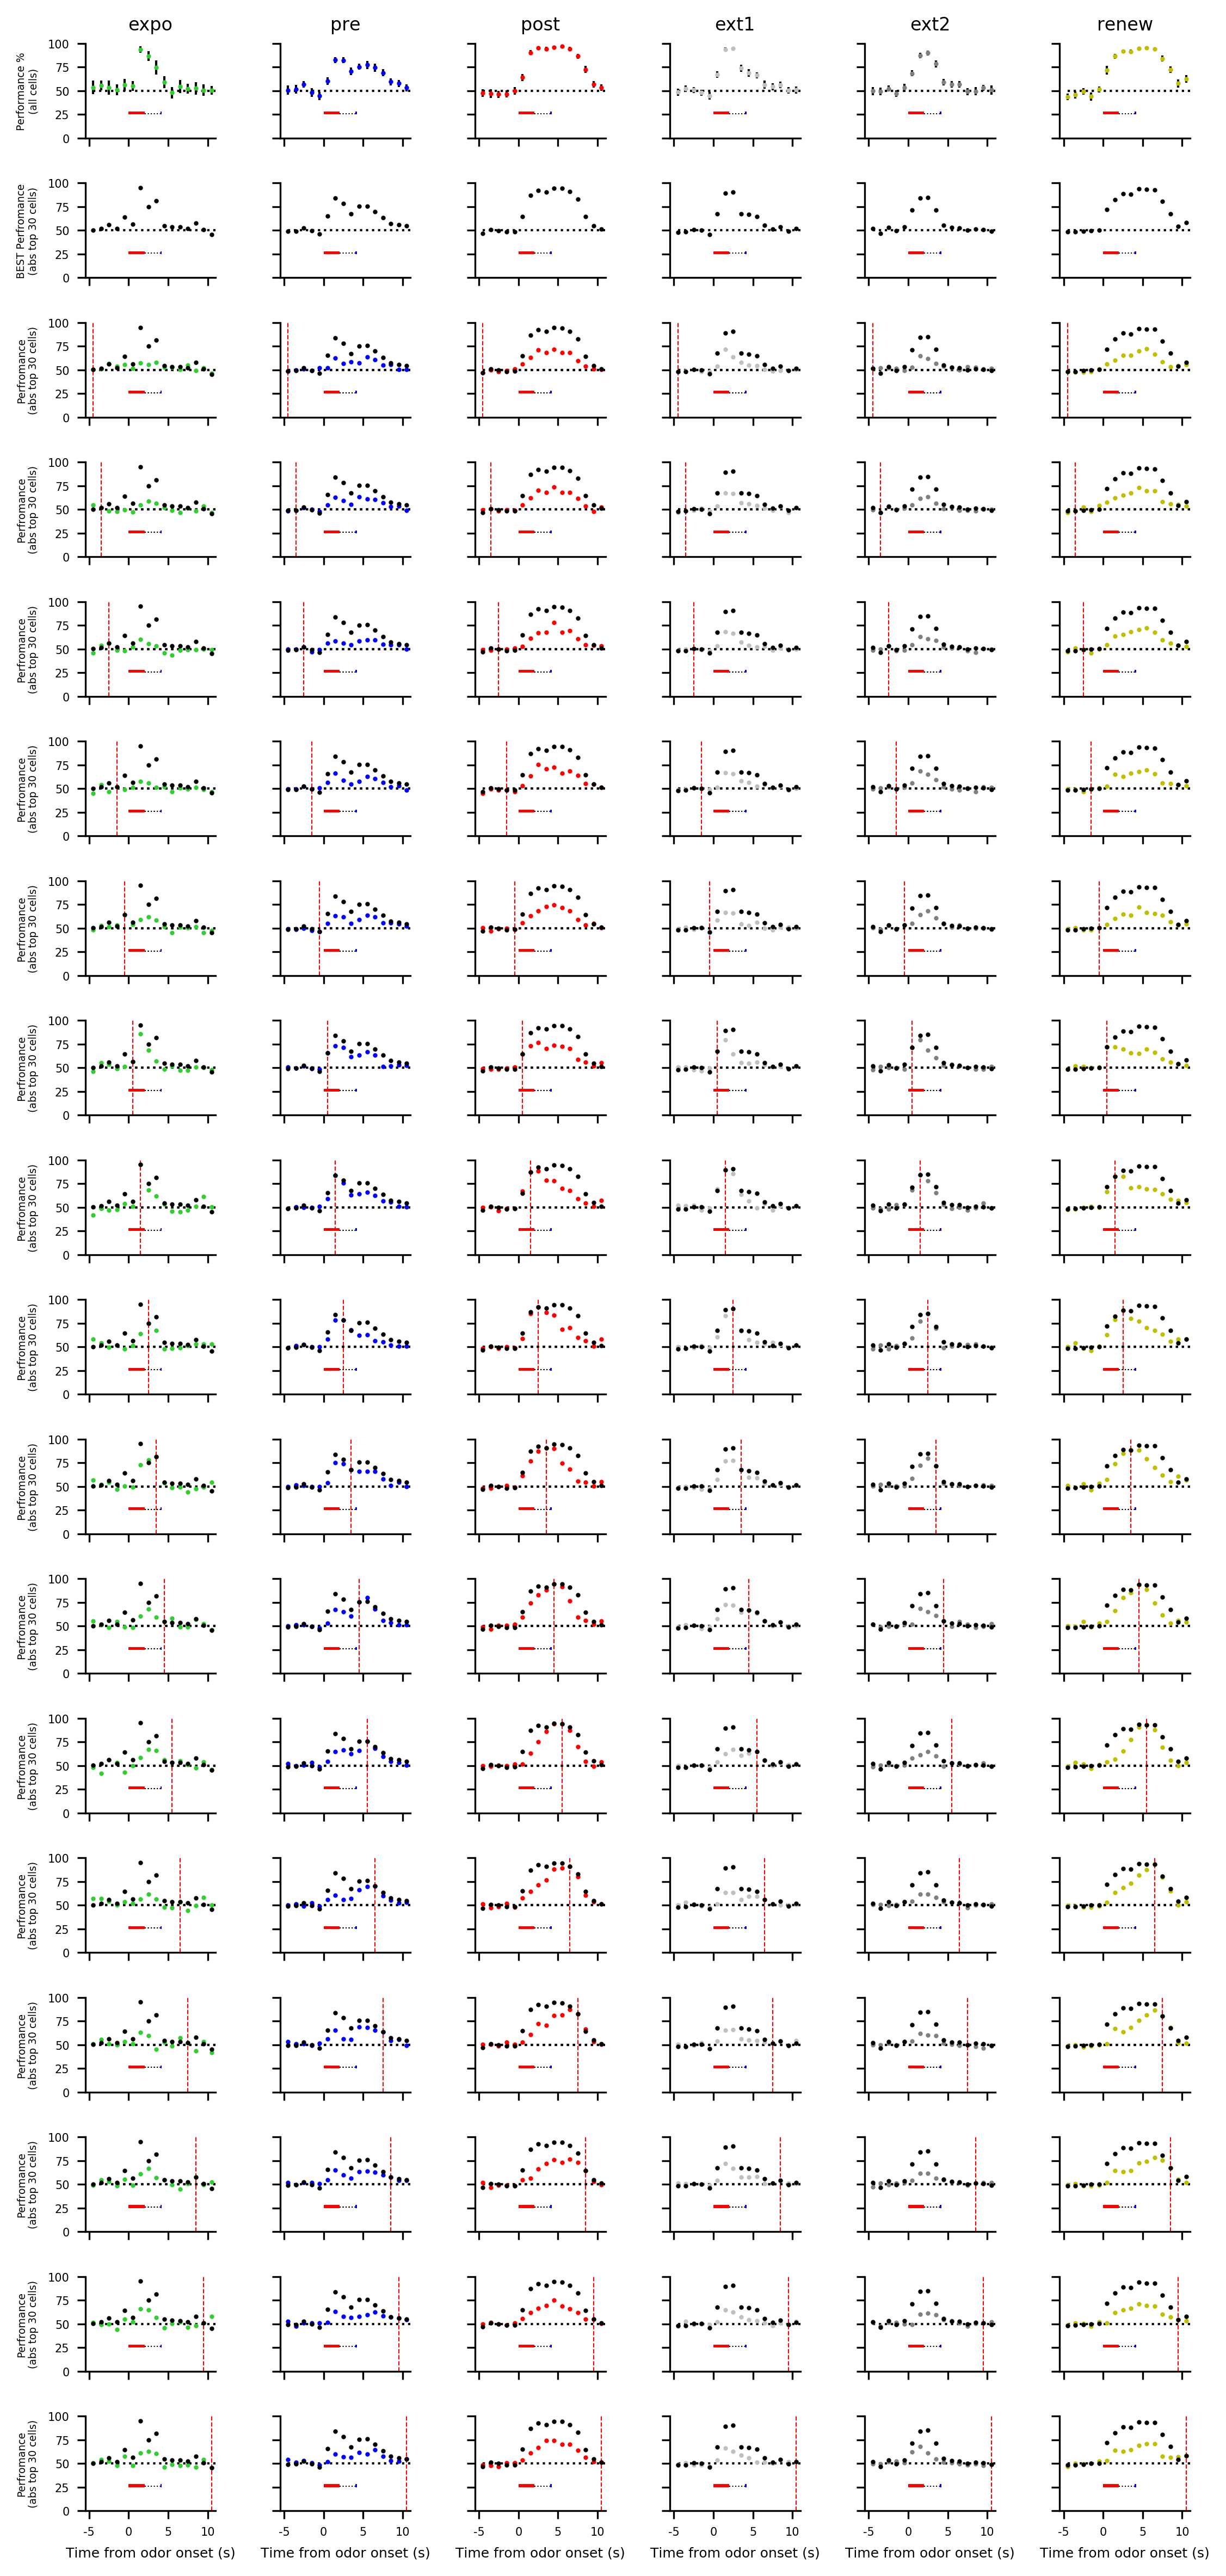

In [27]:
plot_sub_ref_scores('top30',ylabel='Perfromance\n(abs top 30 cells)',subset_cells_overlay=True)

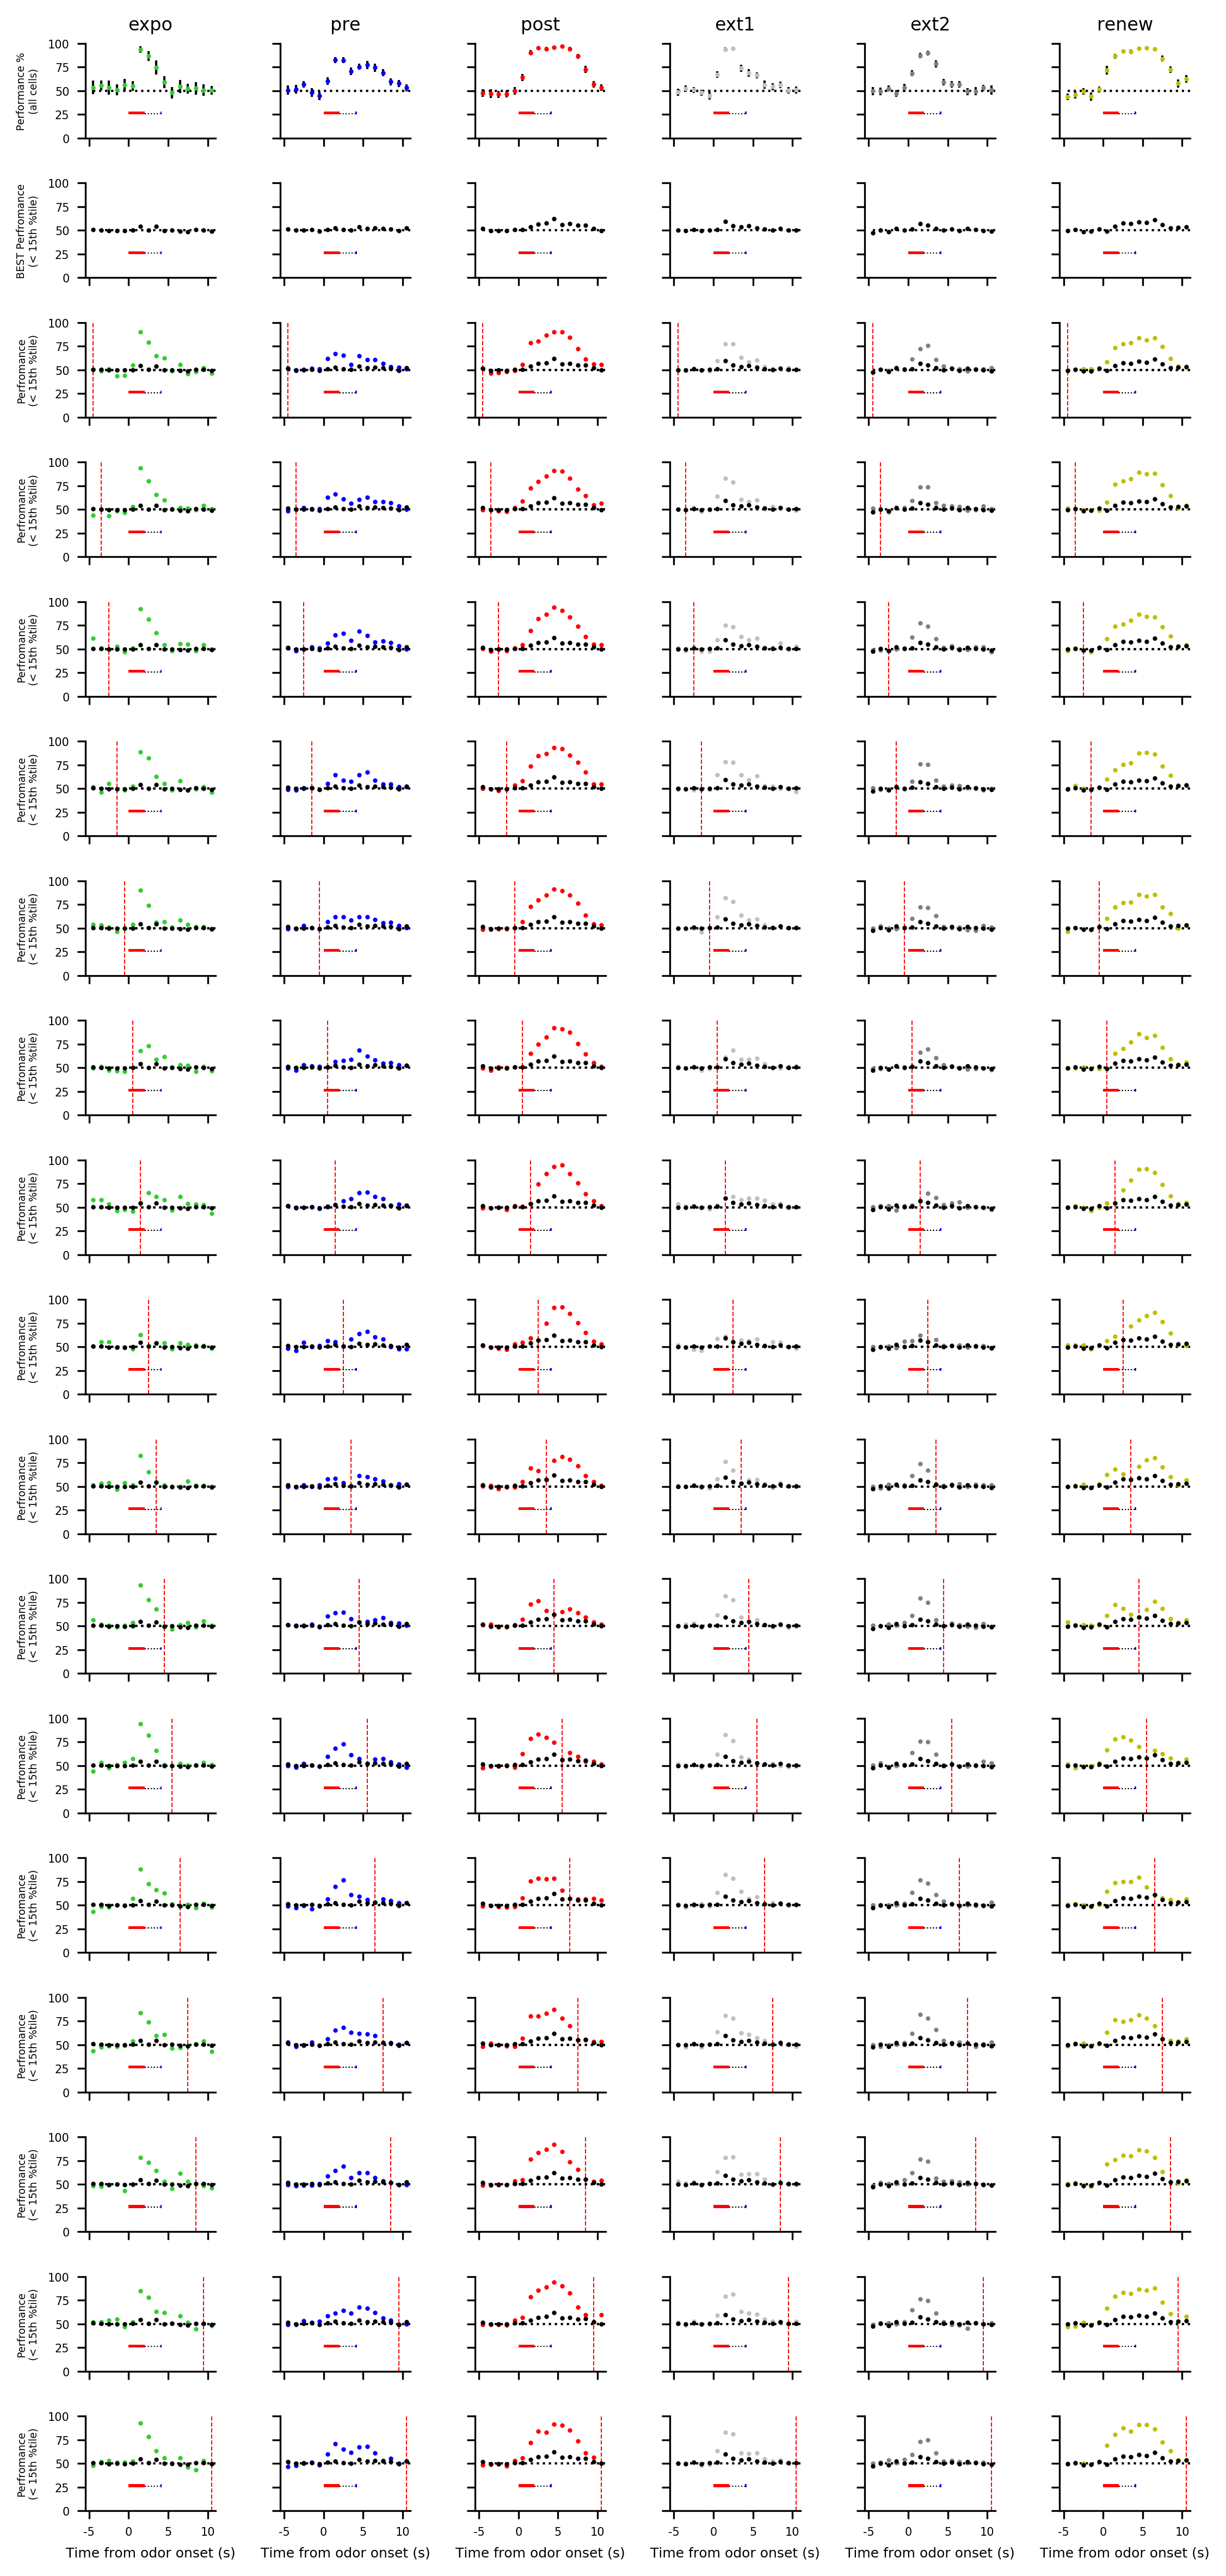

In [28]:
plot_sub_ref_scores('bottomP15',ylabel='Perfromance\n(< 15th %tile)',subset_cells_overlay=True)

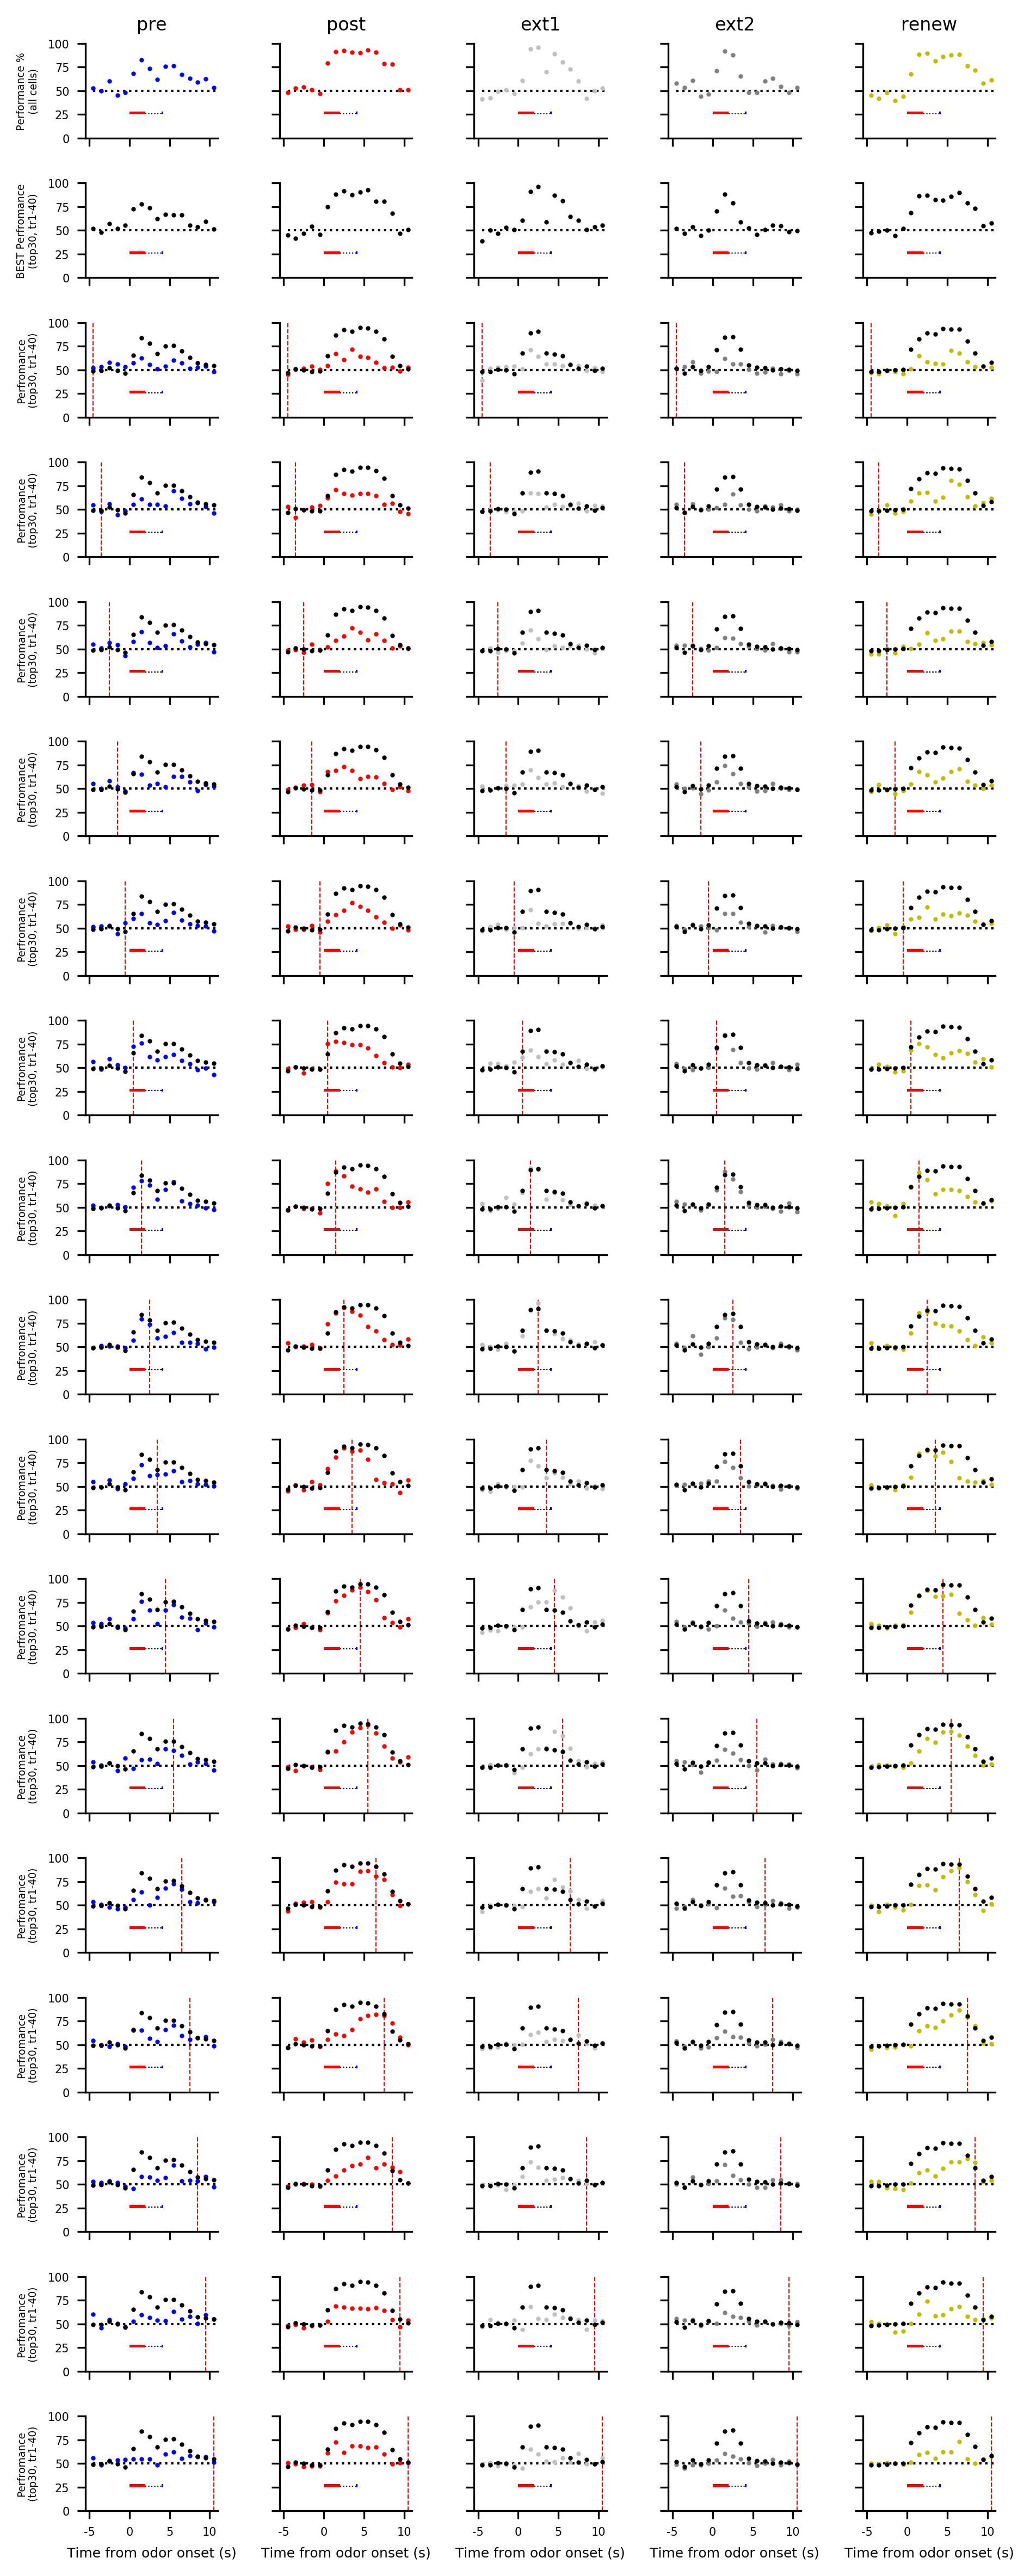

In [29]:
plot_sub_ref_scores('top30',phase='_early',ylabel='Perfromance\n(top30, tr1-40)',subset_cells_overlay=True,exclude_expo=True)

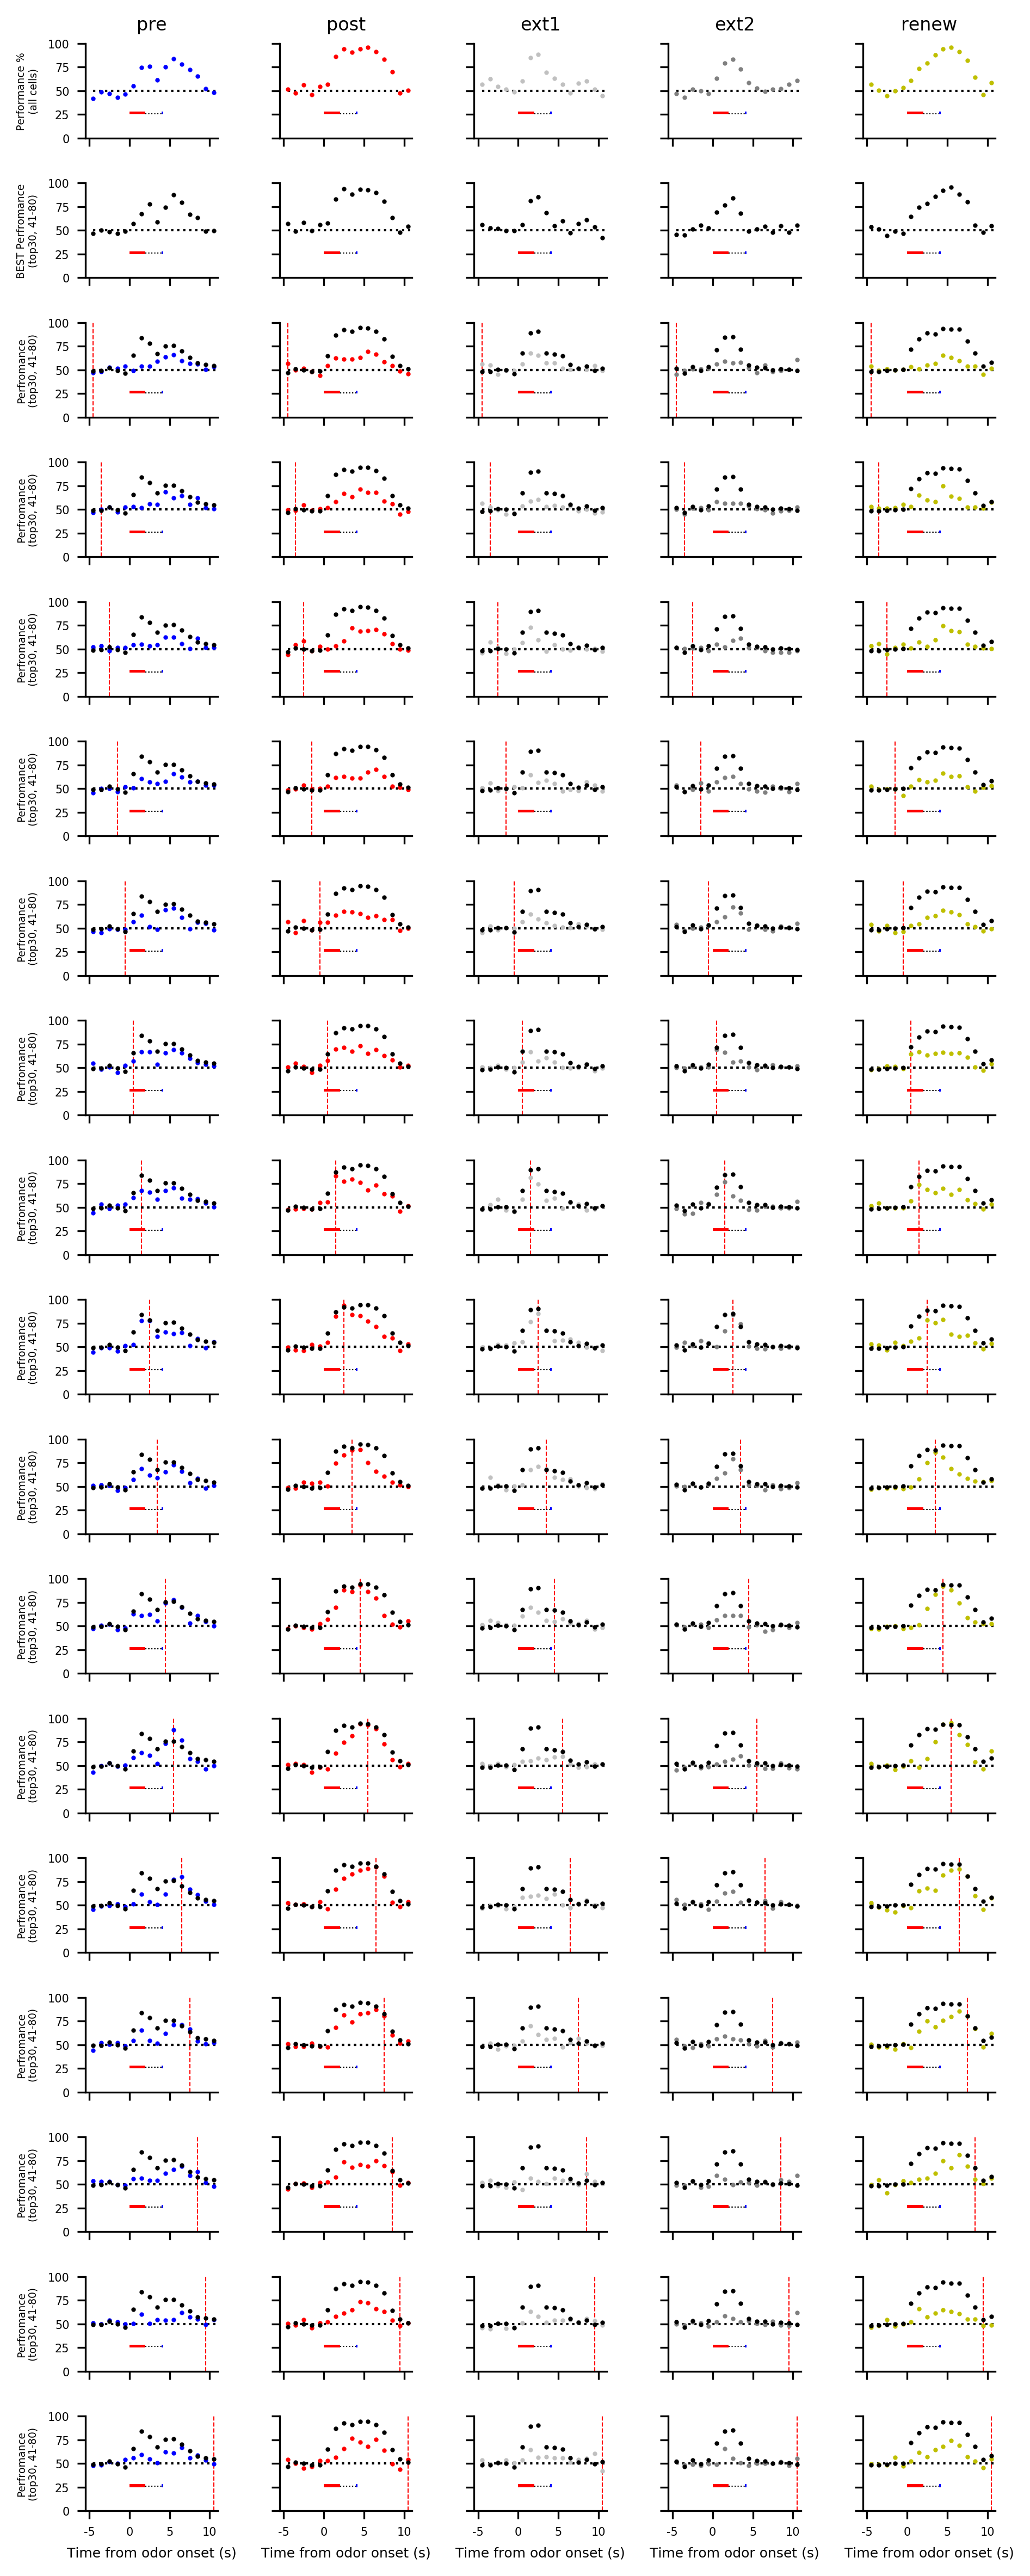

In [30]:
plot_sub_ref_scores('top30',phase='_mid',ylabel='Perfromance\n(top30, 41-80)',subset_cells_overlay=True,exclude_expo=True)

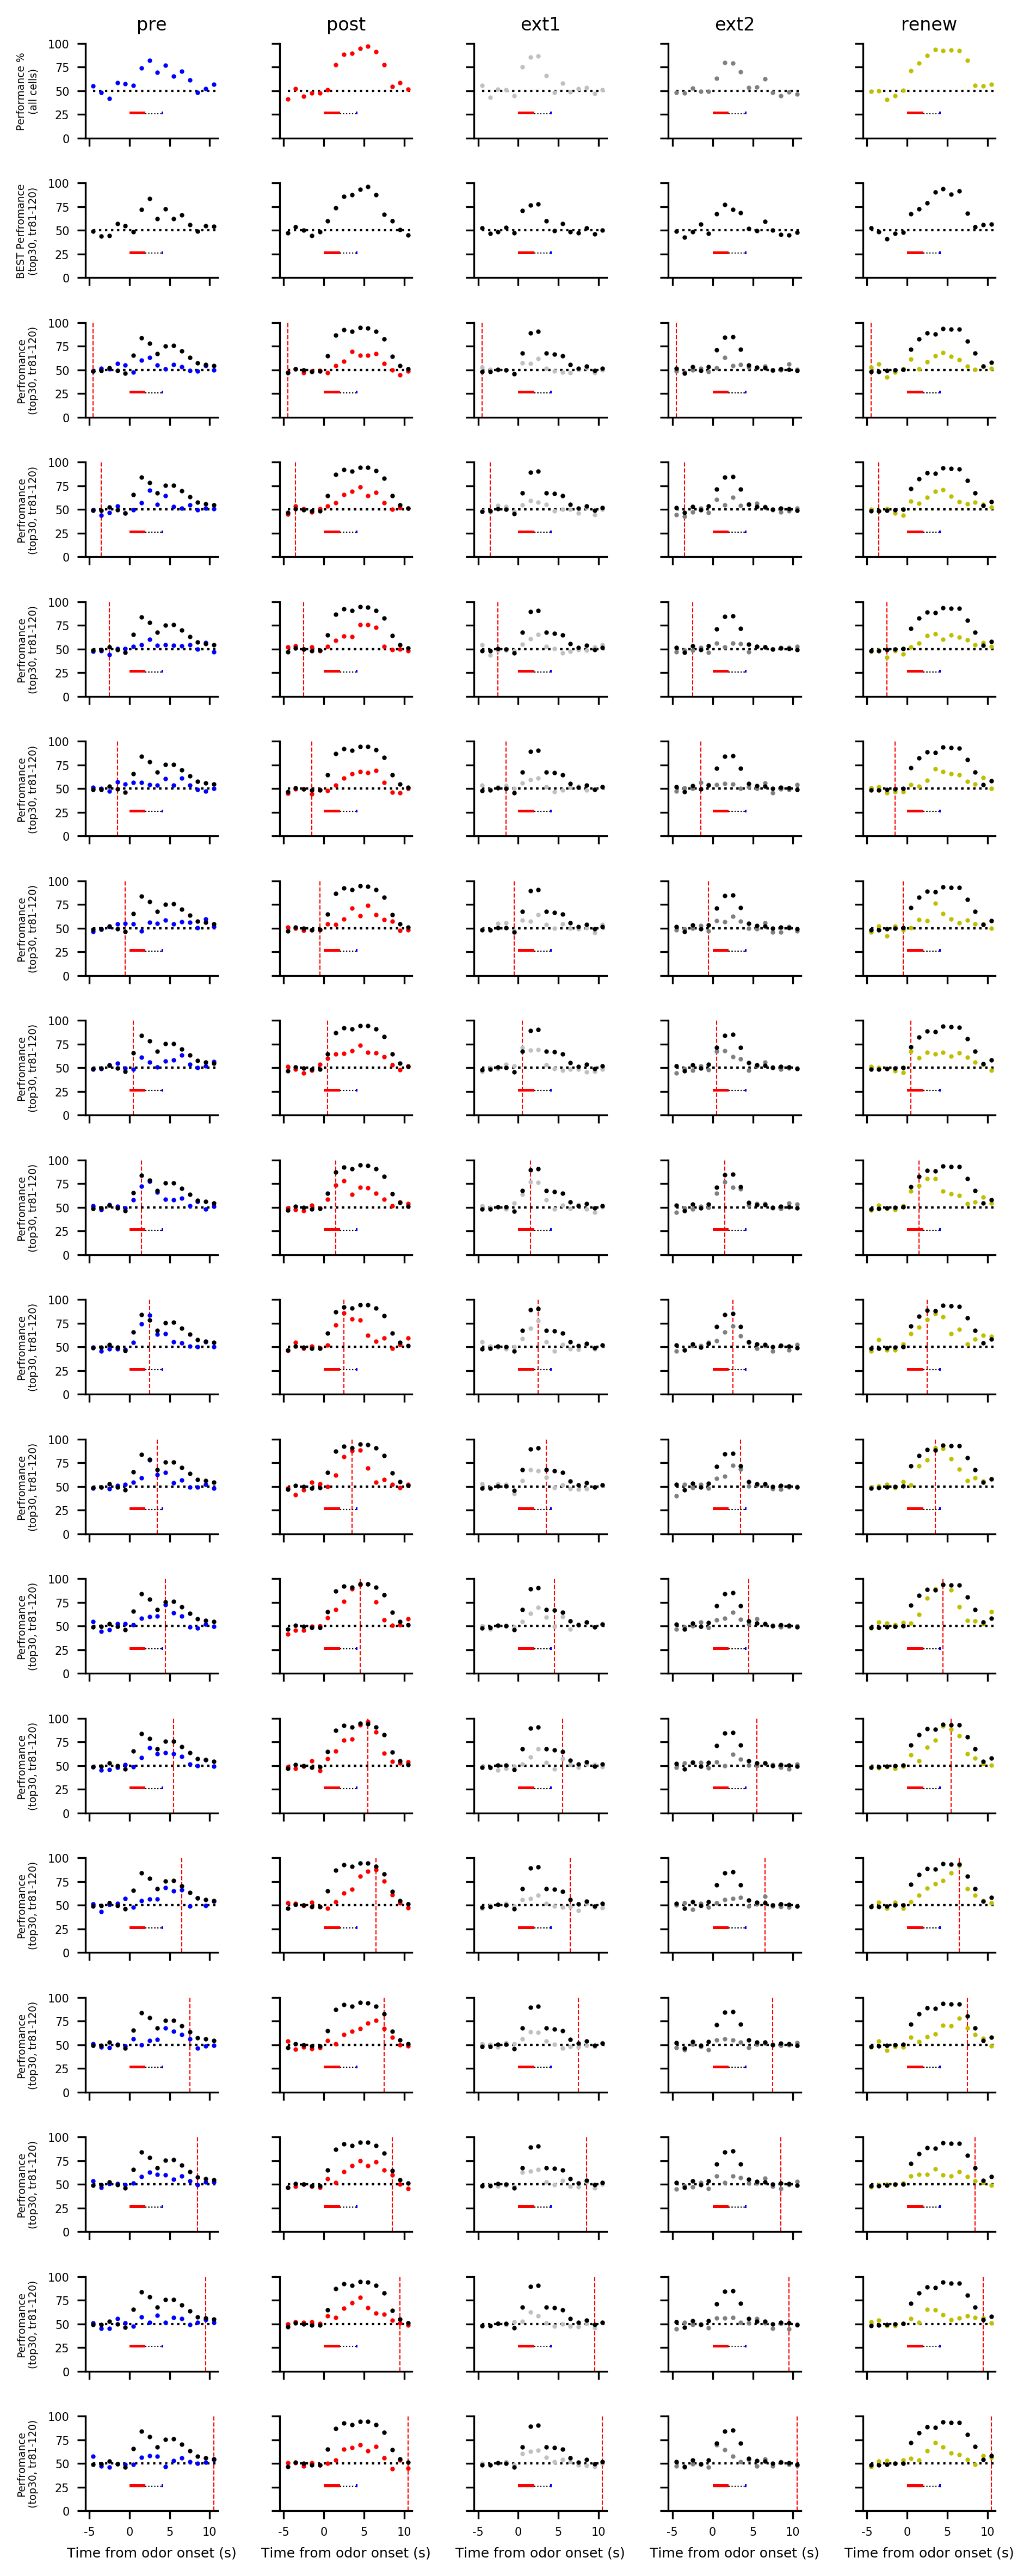

In [31]:
plot_sub_ref_scores('top30',phase='_late',ylabel='Perfromance\n(top30, tr81-120)',subset_cells_overlay=True,exclude_expo=True)

In [33]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
